## Imports

### Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

### Custom

In [2]:
from cv_geoguessr.data.StreetViewImagesDataset import StreetViewImagesDataset

from cv_geoguessr.grid.grid_partitioning import Partitioning

from cv_geoguessr.utils.plot_images import plot_images

## Colab specific

Run only when using Colab.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## Model constants

In [3]:
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 100
CELL_WIDTH = 0.04

SAMPLES_TO_SHOW = 5

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])

CITY_BOUNDS_FILE = '../data/metadata/citybounds/london.csv'

COLAB_LONDON_PHOTO_DIR = lambda train: f'/content/drive/MyDrive/Documents/University/2021-2022/CS4245 Computer Vision/data/images/{"train" if train else "test"}/london'
LOCAL_LONDON_PHOTO_DIR = lambda train: f'../data/images/london/{"train" if train else "test"}'

LONDON_PHOTO_DIR = LOCAL_LONDON_PHOTO_DIR


### ImageNet setup

In [19]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt

--2022-05-15 23:12:21--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10,23K  --.-KB/s    in 0,002s  

2022-05-15 23:12:21 (4,42 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [4]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

## Download ResNet50

In [5]:
resnet50 = models.resnet50(True, True)

In [8]:
summary(resnet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Load the data

### Create the data loaders

In [7]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

grid_partitioning = Partitioning(CITY_BOUNDS_FILE, CELL_WIDTH)

train_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(True), grid_partitioning, data_transforms)
train_loader = DataLoader(train_data_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(False), grid_partitioning, data_transforms)
test_loader = DataLoader(test_data_set, batch_size=TEST_BATCH_SIZE, shuffle=True)


### Preview some training images

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


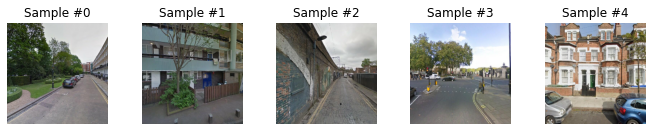

In [8]:
examples = enumerate(test_loader)
batch_idx, (eval_images, eval_coordinates) = next(examples)

plot_images(eval_images[:SAMPLES_TO_SHOW], IMAGENET_MEAN, IMAGENET_STD)

## Evaluate the model

In [11]:
resnet50.eval()

check_images = eval_images[:SAMPLES_TO_SHOW]

with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(check_images), dim=1)

In [13]:
for i in output:
    top5_prob, top5_catid = torch.topk(i, 5)

    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())

    print()

limousine 0.494861900806427
convertible 0.15715351700782776
cab 0.10455919802188873
sports car 0.046823348850011826
beach wagon 0.023714642971754074

dam 0.5563629269599915
prison 0.140448197722435
patio 0.043819084763526917
bannister 0.042140405625104904
castle 0.03014199063181877

planetarium 0.11371709406375885
water tower 0.09709981828927994
prison 0.08581230044364929
dome 0.078342504799366
traffic light 0.07234091311693192

limousine 0.9999208450317383
minivan 5.1376220653764904e-05
police van 5.890528882446233e-06
beach wagon 2.9792192890454317e-06
cab 2.792907707771519e-06

streetcar 0.6648581027984619
trolleybus 0.07793936878442764
passenger car 0.07603776454925537
police van 0.021916277706623077
traffic light 0.0189041867852211



torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


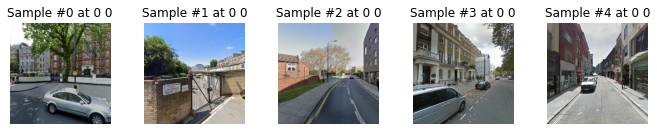

In [14]:
plot_images(check_images, IMAGENET_MEAN, IMAGENET_STD)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
resnet50.fc = nn.Linear(resnet50.fc.in_features, NUMBER_OF_GRID_ELEMENTS)